In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from datetime import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import pacf
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# Verinin yüklenmesi

In [99]:
data=pd.read_csv("traffic_density_202001.csv")

In [100]:
data.head()

,DATE_TIME,LONGITUDE,LATITUDE,GEOHASH,MINIMUM_SPEED,MAXIMUM_SPEED,AVERAGE_SPEED,NUMBER_OF_VEHICLES
0,2020-01-03 13:00:00,28.844604,41.113586,sxk9bk,9,78,53,105
1,2020-01-16 07:00:00,29.152222,41.009216,sxk9r3,6,64,27,68
2,2020-01-17 20:00:00,28.471069,41.042175,sxk1rz,53,96,72,11
3,2020-01-14 22:00:00,29.360962,40.816956,sxkbhn,17,128,73,216
4,2020-01-17 20:00:00,28.844604,40.970764,sxk906,16,82,55,123


In [101]:
data1=data[data['GEOHASH']=='sxk9bk']
data1.head()

,DATE_TIME,LONGITUDE,LATITUDE,GEOHASH,MINIMUM_SPEED,MAXIMUM_SPEED,AVERAGE_SPEED,NUMBER_OF_VEHICLES
0,2020-01-03 13:00:00,28.844604,41.113586,sxk9bk,9,78,53,105
6042,2020-01-10 16:00:00,28.844604,41.113586,sxk9bk,12,90,55,83
8485,2020-01-14 03:00:00,28.844604,41.113586,sxk9bk,19,77,59,16
11710,2020-01-06 15:00:00,28.844604,41.113586,sxk9bk,12,78,53,131
14063,2020-01-22 18:00:00,28.844604,41.113586,sxk9bk,6,82,50,140


In [102]:
data1=data1[['DATE_TIME','NUMBER_OF_VEHICLES']]
data1.head()

,DATE_TIME,NUMBER_OF_VEHICLES
0,2020-01-03 13:00:00,105
6042,2020-01-10 16:00:00,83
8485,2020-01-14 03:00:00,16
11710,2020-01-06 15:00:00,131
14063,2020-01-22 18:00:00,140


In [103]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1328624 entries, 0 to 1328623
Data columns (total 8 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   DATE_TIME           1328624 non-null  object 
 1   LONGITUDE           1328624 non-null  float64
 2   LATITUDE            1328624 non-null  float64
 3   GEOHASH             1328624 non-null  object 
 4   MINIMUM_SPEED       1328624 non-null  int64  
 5   MAXIMUM_SPEED       1328624 non-null  int64  
 6   AVERAGE_SPEED       1328624 non-null  int64  
 7   NUMBER_OF_VEHICLES  1328624 non-null  int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 81.1+ MB


In [104]:
data1['DATE_TIME'] = pd.to_datetime(data1['DATE_TIME'])
data1.index=data1['DATE_TIME']
data1=data1.sort_index(axis=0)
data1=data1.drop(['DATE_TIME'],axis=1)
data1.head()

,NUMBER_OF_VEHICLES
DATE_TIME,
2020-01-01 00:00:00,56
2020-01-01 01:00:00,35
2020-01-01 02:00:00,22
2020-01-01 03:00:00,13
2020-01-01 04:00:00,13


In [105]:
data1.describe()

,NUMBER_OF_VEHICLES
count,735.000000
mean,84.748299
std,40.901031
min,11.000000
25%,54.500000
50%,85.000000
75%,118.000000
max,176.000000


<AxesSubplot:xlabel='DATE_TIME'>

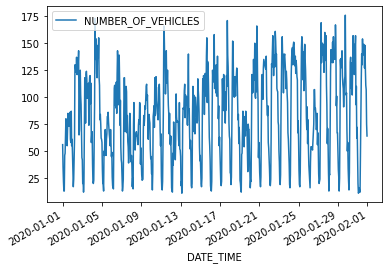

In [106]:
data1.plot()

# Eksik değer kontrolü

In [107]:
nan = data1['NUMBER_OF_VEHICLES'].isnull().any()
nan

False

In [108]:
_range = pd.date_range(start="2020-01-01 00:00:00", end="2020-01-31 23:00:00", freq='H')
lis=_range.difference(data1.index)
lis

DatetimeIndex(['2020-01-02 04:00:00', '2020-01-09 03:00:00',
               '2020-01-26 02:00:00', '2020-01-26 09:00:00',
               '2020-01-26 11:00:00', '2020-01-26 12:00:00',
               '2020-01-27 03:00:00', '2020-01-31 07:00:00',
               '2020-01-31 08:00:00'],
              dtype='datetime64[ns]', freq=None)

In [109]:
len(lis)

9

In [110]:
data2=data1.copy()

In [111]:
data2=data2.asfreq('H')
data2=pd.DataFrame(data2)

In [112]:
nan = data2.isnull().values.any()
nan

True

# Eksik değerlerin doldurulması

### Ortalama değer

In [113]:
mean=data2.copy()

In [114]:
for i in lis:
    index=mean.index.get_loc(i)
    if np.isnan(mean.iloc[index+1]['NUMBER_OF_VEHICLES']) or np.isnan(mean.iloc[index-1]['NUMBER_OF_VEHICLES']):
        
        y=index+1
        z=index-1
        if np.isnan(mean.iloc[y]['NUMBER_OF_VEHICLES']):
            y=index+1
            while np.isnan(mean.iloc[y]['NUMBER_OF_VEHICLES']):
                y=y+1
        if np.isnan(mean.iloc[z]['NUMBER_OF_VEHICLES']):
            z=index-1
            while np.isnan(mean.iloc[z]['NUMBER_OF_VEHICLES']):
                z=z-1
        ort=(mean.iloc[y]['NUMBER_OF_VEHICLES'] + mean.iloc[z]['NUMBER_OF_VEHICLES'])/2 
        mean.iloc[index]['NUMBER_OF_VEHICLES']=ort
        
    else:
        ort=(mean.iloc[index+1]['NUMBER_OF_VEHICLES']+mean.iloc[index-1]['NUMBER_OF_VEHICLES'])/2
        mean.iloc[index]['NUMBER_OF_VEHICLES']=ort

## 2. Önceki veya sonraki değeri atama

In [115]:
before=data2.copy()

In [116]:
before=before.fillna(method='bfill')

Text(0.5, 1.0, 'önceki değer')

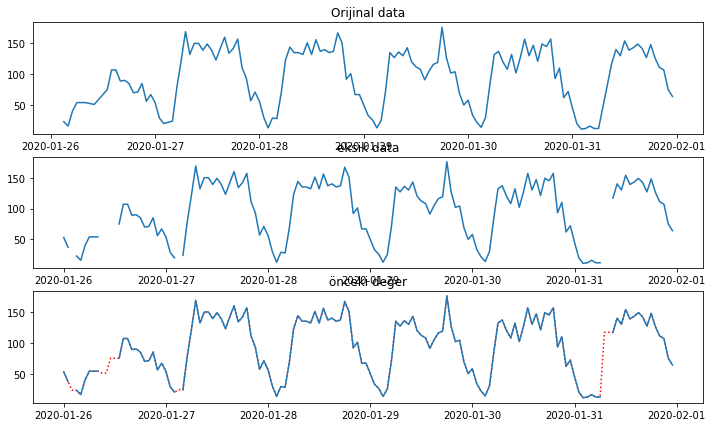

In [117]:
figure, axis = plt.subplots(3, 1,figsize=(12,7))
axis[0].plot(data1[600:])
axis[0].set_title("Orijinal data")
axis[1].plot(data2[600:])
axis[1].set_title("eksik data")
axis[2].plot(before[600:],color='red',linestyle='dotted')
axis[2].plot(data2[600:])
axis[2].set_title("önceki değer")

In [118]:
from prophet import Prophet

In [119]:
pr=data1.copy()
pr = pr.reset_index()
pr.columns = ['ds', 'y']
pr

,ds,y
0,2020-01-01 00:00:00,56
1,2020-01-01 01:00:00,35
2,2020-01-01 02:00:00,22
3,2020-01-01 03:00:00,13
4,2020-01-01 04:00:00,13
...,...,...
730,2020-01-31 19:00:00,126
731,2020-01-31 20:00:00,111
732,2020-01-31 21:00:00,107
733,2020-01-31 22:00:00,75


In [120]:
model = Prophet(interval_width=0.99, yearly_seasonality=False, weekly_seasonality=True, daily_seasonality=True)
model.fit(pr)
forecast = model.predict(pr)

10:25:53 - cmdstanpy - INFO - Chain [1] start processing
10:25:53 - cmdstanpy - INFO - Chain [1] done processing


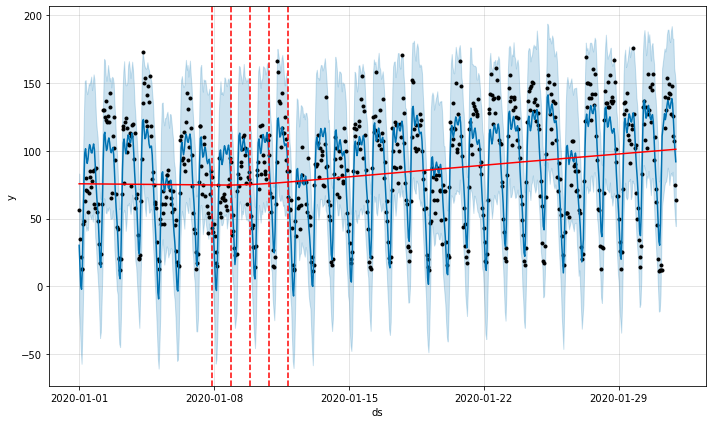

In [121]:
from prophet.plot import add_changepoints_to_plot
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

In [122]:
model.changepoints

23    2020-01-01 23:00:00
47    2020-01-03 00:00:00
70    2020-01-03 23:00:00
94    2020-01-04 23:00:00
117   2020-01-05 22:00:00
141   2020-01-06 22:00:00
164   2020-01-07 21:00:00
188   2020-01-08 21:00:00
211   2020-01-09 21:00:00
235   2020-01-10 21:00:00
258   2020-01-11 20:00:00
282   2020-01-12 20:00:00
305   2020-01-13 19:00:00
329   2020-01-14 19:00:00
352   2020-01-15 18:00:00
376   2020-01-16 18:00:00
399   2020-01-17 17:00:00
423   2020-01-18 17:00:00
446   2020-01-19 16:00:00
470   2020-01-20 16:00:00
493   2020-01-21 15:00:00
517   2020-01-22 15:00:00
540   2020-01-23 14:00:00
564   2020-01-24 14:00:00
587   2020-01-25 13:00:00
Name: ds, dtype: datetime64[ns]

In [131]:
ver=data1.copy()

In [132]:
ver['day']=ver.index.day
ver['hour']=ver.index.hour
ver['dayofweek']=ver.index.dayofweek
ver['week']=ver.index.weekofyear

C:\Users\engin\AppData\Local\Temp\ipykernel_5276\267209684.py:4: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  ver['week']=ver.index.weekofyear


In [133]:
ver=ver.reset_index()

In [134]:
def is_weekend(ds):
    date = pd.to_datetime(ds)
    if date.dayofweek > 4:
        return 1
    else:
        return 0

In [135]:
ver['weekend'] = ver['DATE_TIME'].apply(is_weekend)

In [136]:
ver.set_index('DATE_TIME',inplace=True)

In [137]:
ver

,NUMBER_OF_VEHICLES,day,hour,dayofweek,week,weekend
DATE_TIME,,,,,,
2020-01-01 00:00:00,56,1,0,2,1,0
2020-01-01 01:00:00,35,1,1,2,1,0
2020-01-01 02:00:00,22,1,2,2,1,0
2020-01-01 03:00:00,13,1,3,2,1,0
2020-01-01 04:00:00,13,1,4,2,1,0
...,...,...,...,...,...,...
2020-01-31 19:00:00,126,31,19,4,5,0
2020-01-31 20:00:00,111,31,20,4,5,0
2020-01-31 21:00:00,107,31,21,4,5,0


In [138]:
lags = 24 * 7

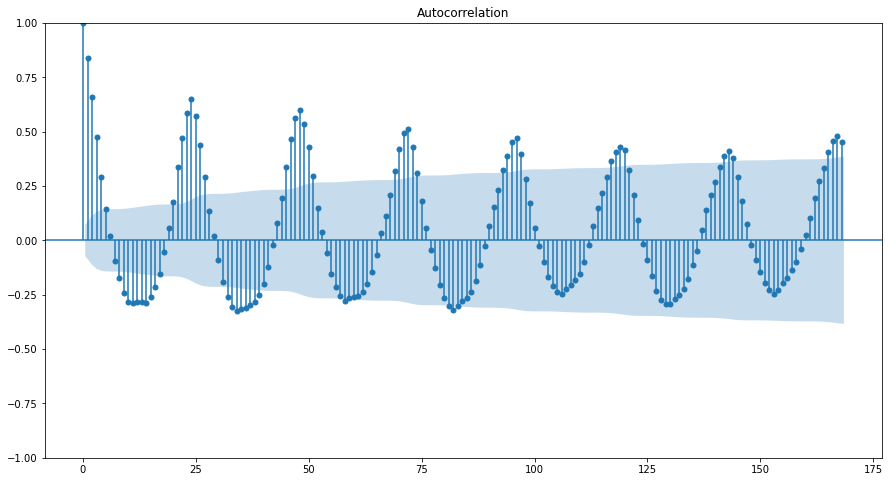

In [139]:
fig, ax = plt.subplots(figsize=(15,8))
plot_acf(x=ver['NUMBER_OF_VEHICLES'], lags= lags,ax=ax);

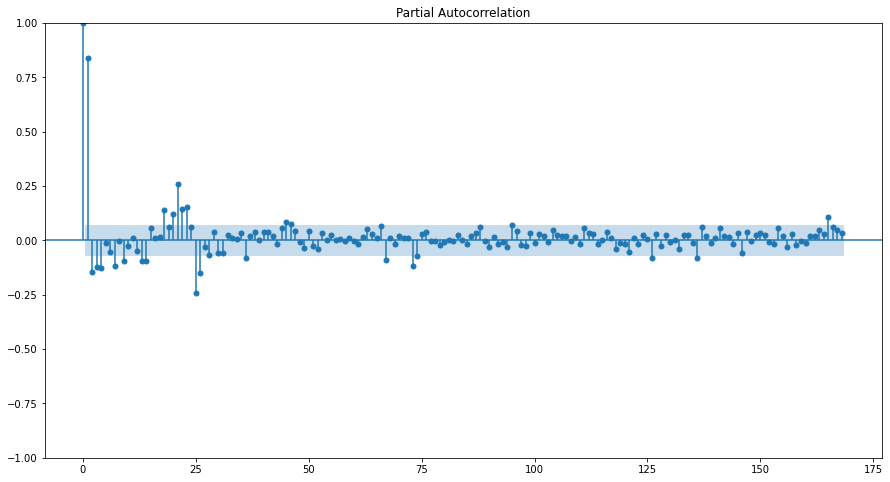

In [140]:
fig, ax = plt.subplots(figsize=(15,8))
plot_pacf(x=ver['NUMBER_OF_VEHICLES'],method='ywm', lags= lags,ax=ax);

In [141]:
lag_df = ver.copy()

In [142]:
for i in range(1, 25):
    lag_df[f"lag_{i}"] = lag_df["NUMBER_OF_VEHICLES"].shift(i)

In [143]:
lag_df

,NUMBER_OF_VEHICLES,day,hour,dayofweek,week,weekend,lag_1,lag_2,lag_3,lag_4,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
DATE_TIME,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,56,1,0,2,1,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 01:00:00,35,1,1,2,1,0,56.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 02:00:00,22,1,2,2,1,0,35.0,56.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 03:00:00,13,1,3,2,1,0,22.0,35.0,56.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 04:00:00,13,1,4,2,1,0,13.0,22.0,35.0,56.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-31 19:00:00,126,31,19,4,5,0,148.0,127.0,142.0,149.0,...,11.0,20.0,45.0,72.0,62.0,110.0,93.0,157.0,145.0,149.0
2020-01-31 20:00:00,111,31,20,4,5,0,126.0,148.0,127.0,142.0,...,12.0,11.0,20.0,45.0,72.0,62.0,110.0,93.0,157.0,145.0
2020-01-31 21:00:00,107,31,21,4,5,0,111.0,126.0,148.0,127.0,...,16.0,12.0,11.0,20.0,45.0,72.0,62.0,110.0,93.0,157.0


In [144]:
corr_df = lag_df[["NUMBER_OF_VEHICLES"]+[f"lag_{i}" for i in range(1, 25)]].corr()

In [145]:
corr_df

,NUMBER_OF_VEHICLES,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
NUMBER_OF_VEHICLES,1.000000,0.838643,0.660516,0.477789,0.293117,0.144806,0.020755,-0.098014,-0.175867,-0.245440,...,-0.267374,-0.222008,-0.159956,-0.053121,0.059535,0.183702,0.348718,0.491073,0.610591,0.674717
lag_1,0.838643,1.000000,0.838657,0.661145,0.478459,0.294088,0.146174,0.021516,-0.097156,-0.175065,...,-0.293892,-0.269294,-0.223830,-0.161528,-0.054552,0.058358,0.182896,0.348301,0.490972,0.610431
lag_2,0.660516,0.838657,1.000000,0.839037,0.661569,0.479149,0.295108,0.146644,0.022032,-0.096779,...,-0.289009,-0.295172,-0.270527,-0.224879,-0.162530,-0.055327,0.057895,0.182677,0.348228,0.490901
lag_3,0.477789,0.661145,0.839037,1.000000,0.838966,0.661416,0.478888,0.294619,0.145836,0.020911,...,-0.289772,-0.288395,-0.294573,-0.269877,-0.224111,-0.161602,-0.054263,0.058666,0.182953,0.348782
lag_4,0.293117,0.478459,0.661569,0.838966,1.000000,0.838902,0.661332,0.478468,0.293872,0.144747,...,-0.295420,-0.288940,-0.287559,-0.293767,-0.268993,-0.223104,-0.160541,-0.053459,0.058957,0.183531
lag_5,0.144806,0.294088,0.479149,0.661416,0.838902,1.000000,0.838726,0.660847,0.477507,0.292395,...,-0.292305,-0.293816,-0.287314,-0.285995,-0.292148,-0.267280,-0.221441,-0.159400,-0.053067,0.059788
lag_6,0.020755,0.146174,0.295108,0.478888,0.661332,0.838726,1.000000,0.838519,0.659841,0.475748,...,-0.252383,-0.289636,-0.291144,-0.284753,-0.283277,-0.289410,-0.264772,-0.219852,-0.159004,-0.051965
lag_7,-0.098014,0.021516,0.146644,0.294619,0.478468,0.660847,0.838519,1.000000,0.838275,0.659210,...,-0.184648,-0.250589,-0.287947,-0.289528,-0.283043,-0.281541,-0.287854,-0.263742,-0.219582,-0.158354
lag_8,-0.175867,-0.097156,0.022032,0.145836,0.293872,0.477507,0.659841,0.838275,1.000000,0.837797,...,-0.108571,-0.181859,-0.248025,-0.285633,-0.287089,-0.280543,-0.279314,-0.286528,-0.263510,-0.218836
lag_9,-0.245440,-0.175065,-0.096779,0.020911,0.144747,0.292395,0.475748,0.659210,0.837797,1.000000,...,0.008295,-0.105117,-0.178681,-0.245255,-0.282844,-0.284261,-0.278021,-0.277831,-0.286357,-0.262791


In [146]:
corrvalues=corr_df.NUMBER_OF_VEHICLES.values

In [147]:
selected_lags_2 = np.where((corrvalues>0.6)|(corrvalues<-0.6))[0]

In [148]:
selected_lags_2

array([ 0,  1,  2, 23, 24], dtype=int64)

In [149]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits = 3)

In [150]:
X = lag_df.drop(labels=['NUMBER_OF_VEHICLES'], axis=1)
y = lag_df['NUMBER_OF_VEHICLES']

In [151]:
params={"n_estimators":[5,10,20,50],
      "max_depth":[3,6,9],
      "learning_rate":[0.001,0.01,0.1,1]}

In [152]:
for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [68]:
import lightgbm as lgb
import optuna
from sklearn.model_selection import GridSearchCV

In [88]:
model = lgb.LGBMRegressor(learning_rate=0.1,max_depth=3,n_estimators=50)
model.fit(X_train,y_train)
pred = model.predict(X_test)

In [89]:
pl=pd.DataFrame(y_test)
pl['pred']=pred
pl

,NUMBER_OF_VEHICLES,pred
DATE_TIME,,
2020-01-24 02:00:00,19,21.296793
2020-01-24 03:00:00,16,21.405106
2020-01-24 04:00:00,28,22.557661
2020-01-24 05:00:00,77,71.268811
2020-01-24 06:00:00,121,111.036562
...,...,...
2020-01-31 19:00:00,126,131.564065
2020-01-31 20:00:00,111,121.059193
2020-01-31 21:00:00,107,111.142077


In [ ]:
plt.plot(pl)

In [91]:
def objective(trial):
    
    param = {'objective': 'regression','metric': 'MAE',
             'num_leaves': trial.suggest_int('num_leaves', 2, 256),
             'learning_rate': trial.suggest_uniform('learning_rate',0.01,1),
             'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
             'max_depth': trial.suggest_int("max_depth", 6, 20)}
    
    dtrain = lgb.Dataset(X_train, label=y_train)

    model = lgb.LGBMRegressor(**param)
    model.fit(X_train,y_train)
    pred = model.predict(X_test)
    accuracy = Prophet_mae = mean_absolute_error(y_test, pred)
    return accuracy

In [92]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
 
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2022-08-17 10:22:58,744] A new study created in memory with name: no-name-c3c0af9e-6365-40a9-a6e9-17579274bb89
[I 2022-08-17 10:22:58,837] Trial 0 finished with value: 15.523309017762292 and parameters: {'num_leaves': 121, 'learning_rate': 0.7940955794752926, 'min_child_samples': 45, 'max_depth': 6}. Best is trial 0 with value: 15.523309017762292.
[I 2022-08-17 10:22:58,886] Trial 1 finished with value: 15.170427079529736 and parameters: {'num_leaves': 118, 'learning_rate': 0.49797183573626863, 'min_child_samples': 78, 'max_depth': 7}. Best is trial 0 with value: 15.523309017762292.
[I 2022-08-17 10:22:58,936] Trial 2 finished with value: 14.653608296238803 and parameters: {'num_leaves': 93, 'learning_rate': 0.5911827742085203, 'min_child_samples': 72, 'max_depth': 17}. Best is trial 0 with value: 15.523309017762292.
[I 2022-08-17 10:22:58,994] Trial 3 finished with value: 13.948280352085558 and parameters: {'num_leaves': 183, 'learning_rate': 0.49235123010607096, 'min_child_samples

[I 2022-08-17 10:23:01,383] Trial 32 finished with value: 16.12947875128253 and parameters: {'num_leaves': 116, 'learning_rate': 0.9190168093519696, 'min_child_samples': 62, 'max_depth': 13}. Best is trial 28 with value: 17.498532878136.
[I 2022-08-17 10:23:01,450] Trial 33 finished with value: 15.195873972228508 and parameters: {'num_leaves': 19, 'learning_rate': 0.6668611286902761, 'min_child_samples': 66, 'max_depth': 6}. Best is trial 28 with value: 17.498532878136.
[I 2022-08-17 10:23:01,517] Trial 34 finished with value: 15.983304507512555 and parameters: {'num_leaves': 46, 'learning_rate': 0.8485342851054777, 'min_child_samples': 54, 'max_depth': 12}. Best is trial 28 with value: 17.498532878136.
[I 2022-08-17 10:23:01,621] Trial 35 finished with value: 14.994321668330567 and parameters: {'num_leaves': 106, 'learning_rate': 0.9325322940236777, 'min_child_samples': 15, 'max_depth': 9}. Best is trial 28 with value: 17.498532878136.
[I 2022-08-17 10:23:01,686] Trial 36 finished wit

[I 2022-08-17 10:23:03,528] Trial 65 finished with value: 14.881747046332654 and parameters: {'num_leaves': 11, 'learning_rate': 0.8069837405345597, 'min_child_samples': 74, 'max_depth': 14}. Best is trial 28 with value: 17.498532878136.
[I 2022-08-17 10:23:03,627] Trial 66 finished with value: 15.875974677277759 and parameters: {'num_leaves': 28, 'learning_rate': 0.901944481011465, 'min_child_samples': 11, 'max_depth': 11}. Best is trial 28 with value: 17.498532878136.
[I 2022-08-17 10:23:03,690] Trial 67 finished with value: 13.508205435417688 and parameters: {'num_leaves': 51, 'learning_rate': 0.24818016384224523, 'min_child_samples': 49, 'max_depth': 12}. Best is trial 28 with value: 17.498532878136.
[I 2022-08-17 10:23:03,763] Trial 68 finished with value: 15.922667765305318 and parameters: {'num_leaves': 240, 'learning_rate': 0.8408491465550094, 'min_child_samples': 53, 'max_depth': 13}. Best is trial 28 with value: 17.498532878136.
[I 2022-08-17 10:23:03,833] Trial 69 finished w

[I 2022-08-17 10:23:06,401] Trial 98 finished with value: 17.240979410760353 and parameters: {'num_leaves': 110, 'learning_rate': 0.8767806716247046, 'min_child_samples': 27, 'max_depth': 8}. Best is trial 94 with value: 17.949388038479434.
[I 2022-08-17 10:23:06,488] Trial 99 finished with value: 16.989425272496113 and parameters: {'num_leaves': 106, 'learning_rate': 0.8064240639387815, 'min_child_samples': 27, 'max_depth': 8}. Best is trial 94 with value: 17.949388038479434.


Number of finished trials: 100
Best trial: {'num_leaves': 44, 'learning_rate': 0.9549035624934694, 'min_child_samples': 21, 'max_depth': 12}


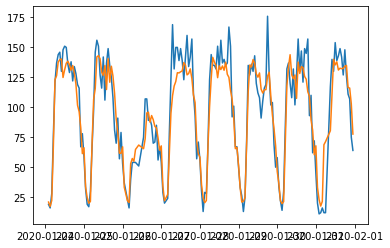

In [93]:
model = lgb.LGBMRegressor(num_leaves=44,learning_rate=0.1,max_depth=12,min_child_samples=21,n_estimators=50)
model.fit(X_train,y_train)
pred = model.predict(X_test)
pl=pd.DataFrame(y_test)
pl['pred']=pred
plt.plot(pl)

In [95]:
lgb_mae = mean_absolute_error(y_test, pred)
lgb_mae

12.984768468080153